# Multiple Linear Correlation including all "behavioral" (subject-specific) variables.

Will attempt to predict ROIs' properties based on a set of subject-specific ones.

## Import required modules & packages

(uncomment first line to install them)

In [1]:
#!pip install scikit-learn pandas matplotlib seaborn pysurfer
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from neurocov.vis.utils import df_to_nifti, nifti_to_surface_png

# sns.set_style("whitegrid")
# sns.set_context("poster", font_scale=1, rc={"grid.linewidth": 5})

## Read relevant data

Also "tag" categorical and numeric variables

In [2]:
all_data = pd.read_pickle("../data/data_combined.pickle")
parcels = pd.read_csv("../data/BNA_with_cerebellum.csv", index_col=0)
atlas_image_path = "../data/BN_Atlas_274_combined_1mm.nii.gz"

all_mr_data, all_subject_details, all_session_details, all_metrics = [
    all_data[col] for col in ["brainnetome", "questionnaire", "session_details", "metric"]
]

destination = Path("../results/single_correlations")
destination.mkdir(parents=True,exist_ok=True)

## Remove subjects with multiple sessions.
Since the overall goal is to set a platform for removal of confound variables from longitudinal studies, we would like to "keep" these subjects for later analyses.

To avoid drifting of information from one set of models to another, we will currently drop them.

In [3]:
sessions = all_session_details.copy()
sessions.loc[all_metrics.index,"metric"] = all_metrics
sessions.loc[all_subject_details.index,"participant"] = all_subject_details["participant"]
sessions.drop_duplicates(subset=["participant","metric"],keep=False,inplace=True)

single_session_participants = sessions["participant"].unique()
single_session_indices = sessions.index
print(f"Found a total of {len(single_session_participants)} participants with only one session")

Found a total of 212 participants with only one session


## Extract features of interest
Although there are a lot of features available, we will only use a subset of them to establish the paradigm of confound removal.

Other researchers may find it valuable to include other features as possible confounders/covariates, but it should be considered in the light of the studied domain.

In [4]:
numeric_columns = ["Age (years)", "Weight (kg)", "Height (cm)"]
categorical_columns = ["Sex", "Dominant Hand"]
subject_details = all_subject_details.loc[single_session_indices,numeric_columns+categorical_columns+["participant"]]
subject_details.loc[single_session_indices,"Dominant Hand"] = subject_details.loc[single_session_indices,"Dominant Hand"].replace({"L":"Left","R":"Right"})

In [5]:
single_sessions_details = sessions.loc[single_session_indices].drop(["timestamp","metric","participant"],axis=1)

In [6]:
features = pd.concat([subject_details,single_sessions_details],axis=1)

## Basic Exploratory Data Analysis (EDA)

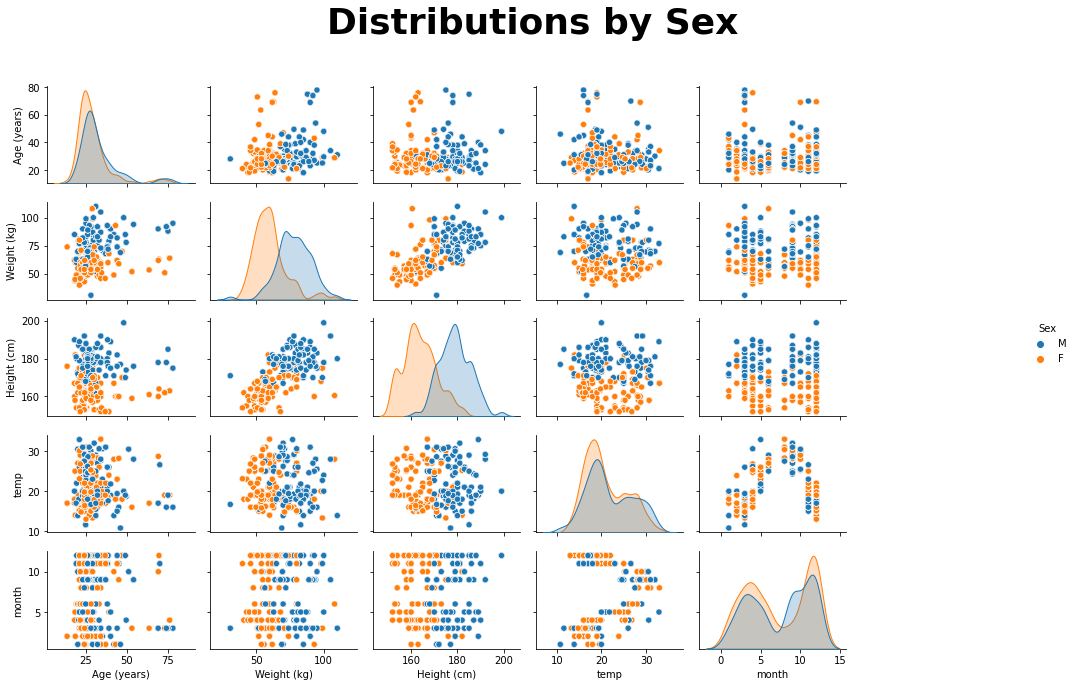

In [7]:
n_categorical = len(categorical_columns)
n_numeric = len(numeric_columns)
vis_features = features[subject_details.columns.tolist()+["temp","month"]]
for categorical_column in categorical_columns:
    ax = sns.pairplot(vis_features,hue=categorical_column,grid_kws ={"diag_sharey":False})
    ax.figure.set_figheight(10)
    ax.figure.set_figwidth(15)
    ax.fig.suptitle(f"Distributions by {categorical_column.capitalize()}",fontsize=36,fontweight="bold")
    ax.fig.tight_layout(rect=[0, 0.03, 0.8, 0.95])
    ax.legend.set_title(categorical_column.capitalize())
    break

## Categorical data preprocessing

Will use One Hot Encoding to describe categorical variables

In [8]:
processed_features = features.copy()

dummies = pd.get_dummies(processed_features[categorical_columns], drop_first=True)
processed_features = processed_features.join(dummies)
processed_features.drop(categorical_columns, axis=1, inplace=True)

## Preprocessing of continous variables
Will use standard scaling to transform continous variable to units describing deviation from population's mean.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

all_numeric_columns = numeric_columns+single_sessions_details.columns.to_list()
processed_features[all_numeric_columns] = scaler.fit_transform(processed_features[all_numeric_columns])

## Remove missing data
Although there isn't a a lot of missing information, it's preferable to avoid analyzing missing data.

In [10]:
processed_features = processed_features.dropna(how="any")

valid_subjects = processed_features["participant"].unique()

print(f"Found a total of {len(valid_subjects)} valid subjects")

Found a total of 176 valid subjects


## Finally, extract MRI-derived data associated with "valid" subjects

In [11]:
mr_data = all_mr_data.loc[processed_features.index]
metrics = all_metrics.loc[processed_features.index]

In [12]:
# cur_x = X.drop(col, axis=1)
# cols_to_use = cur_x.columns.tolist()
# # cols_to_use = [c for c in cols_to_use if abs(X[col].corr(X[c])) < corr_threshold]
# # X[col].corr(X[cols_to_use[18]])
# cols_to_use[18]

## "Regress out" all variability in MR-derived metrics that can be explained by suggested covariates
We will try to predict MD using these variables, leading to an expected error.

This error can be interpreted as the portion on MD that can't be explained (or predicted) by the variable we chose to use as predictors.

In [14]:
import statsmodels.formula.api as smf
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests

categorical_names = ["Sex","Hand"]

force = True
corr_threshold = 0.15
pred_data = {}
for metric in ["md"]:
    output_directory = destination / metric
    all_stats = pd.DataFrame()
    data = mr_data[metrics == metric]
    X = processed_features.loc[data.index,:].drop(["participant"],axis=1)
    X.columns = [col.split(" ")[0] if "Dominant" not in col else col.split(" ")[1] for col in X.columns]
    for col in ["Age","Height","Weight"]:
        out_csv = output_directory / col / f"stats.csv"
        out_csv.parent.mkdir(exist_ok=True, parents=True)

        # cur_x = X.drop(col, axis=1)
        cur_x = X.copy()
        # cols_to_drop = cur_x.columns.tolist()
        # cols_to_drop = [c for c in cols_to_drop if abs(X[col].corr(X[c])) > corr_threshold]
        # cur_x = cur_x.drop(cols_to_drop,axis=1)
        # print(f"The following columns are being dropped becuase of high correlation with {col}:")
        # print(cols_to_drop)
        formula = col if col not in categorical_names else f"C({col})"
        # for c in cur_x.columns:
        #     if any([categorical_column in c for categorical_column in ["Sex","Hand"]]):
        #         formula += f" + C({c})"
        #     else:
        #         formula += f" + {c}"

        stats = parcels.copy()
        
        stats["loo_variable"] = col
        for i in tqdm(parcels.index):
            roi = parcels.loc[i, "Label"]
            df = cur_x.copy()
            df[col] = X[col]
            df["ROI"] = data[roi]
            cur_formula = f"ROI ~ {formula}"
            model = smf.ols(cur_formula, data=df).fit()
            
            stats.loc[i, "p"] = model.pvalues[col]
            stats.loc[i, "t"] = model.tvalues[col]
            stats.loc[i, "coefficient"] = model.params[col]
            stats.loc[i, "r2"] = model.rsquared
            stats.loc[i, "r2_adj"] = model.rsquared_adj
        stats["p_vis"] = 1 - stats["p"]
        stats["bonferroni_corrected_p_vis"] = 1 - multipletests(stats["p"], method="bonferroni")[1]
        stats.to_csv(out_csv)
        for val, cmap in zip(["t","r2", "p_vis", "bonferroni_corrected_p_vis"], ["RdBu_r","hot", "hot", "hot", "hot"]):
            stats[val].fillna(0, inplace=True)
            if not (stats[val] > 0).any():
                continue
            out_nifti = output_directory / col / f"{val}.nii.gz"
            out_png = output_directory / col / f"{val}.png"
            if Path(out_nifti).exists() and Path(out_png).exists() and not force:
                continue
            img = df_to_nifti(stats, atlas_image_path, val, match_by="Label")
            img.to_filename(out_nifti)
            try:
                nifti_to_surface_png(out_nifti, out_png, colormap=cmap)
            except ValueError:
                continue
        all_stats = pd.concat([all_stats, stats])

100%|██████████| 274/274 [00:00<00:00, 282.30it/s]


Converting dataframe to nifti...
        Matching column: Label.
        Value column: t.


274it [00:04, 66.11it/s]


Converting dataframe to nifti...
        Matching column: Label.
        Value column: r2.


274it [00:02, 95.84it/s]


Converting dataframe to nifti...
        Matching column: Label.
        Value column: p_vis.


274it [00:03, 75.55it/s]


Converting dataframe to nifti...
        Matching column: Label.
        Value column: bonferroni_corrected_p_vis.


274it [00:03, 74.76it/s]


In [18]:
# sns.barplot(data=all_stats[all_stats["Label"] == 56],x = "coefficient", y= "loo_variable")
all_stats.sort_values("p")
# model.summary()
# model.rsquared

,ROIname,Label,Lobe,Gyrus,description,Yeo_7network,Yeo_17network,index,FS_name,Yeo_7network_name,Yeo_17network_name,loo_variable,p,t,coefficient,r2,r2_adj,p_vis,bonferroni_corrected_p_vis
263,Cereb_17,264,Cerebellum,Cerebellum,Unknown,NaN,NaN,263,NaN,NaN,NaN,Weight,0.000248,-3.741303,-5.220314e-05,7.445504e-02,0.069136,0.999752,0.931948
116,TI_L,117,Temporal Lobe,"PhG, Parahippocampal Gyrus",area TI(temporal agranular insular cortex),5.0,9.0,116,TI_L,Limbic,Salience/VenAttn B,Weight,0.000304,-3.685769,-9.876399e-05,7.241999e-02,0.067089,0.999696,0.916605
243,cTtha_R,244,Subcortical Nuclei,"Tha, Thalamus",caudal temporal thalamus,0.0,0.0,243,NaN,Subcortical,Subcortical,Weight,0.001371,-3.253183,-7.997096e-05,5.733566e-02,0.051918,0.998629,0.624365
117,TI_R,118,Temporal Lobe,"PhG, Parahippocampal Gyrus",area TI(temporal agranular insular cortex),5.0,9.0,117,TI_R,Limbic,Salience/VenAttn B,Weight,0.002589,-3.056921,-6.043512e-05,5.096828e-02,0.045514,0.997411,0.290560
215,rHipp_R,216,Subcortical Nuclei,"Hipp, Hippocampus",rostral hippocampus,0.0,0.0,215,NaN,Subcortical,Subcortical,Weight,0.003329,-2.976664,-5.518665e-05,4.845512e-02,0.042986,0.996671,0.087777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,Cereb_22,269,Cerebellum,Cerebellum,Unknown,NaN,NaN,268,NaN,NaN,NaN,Weight,0.995603,-0.005519,-6.465846e-07,1.750556e-07,-0.005747,0.004397,0.000000
61,A4tl_R,62,Frontal Lobe,"PrG, Precentral Gyrus",area 4(tongue and larynx region),4.0,7.0,61,A4tl_R,Ventral Attention,Dorsal Attention B,Weight,0.996018,0.004997,6.486989e-08,1.435284e-07,-0.005747,0.003982,0.000000
267,Cereb_21,268,Cerebellum,Cerebellum,Unknown,NaN,NaN,267,NaN,NaN,NaN,Weight,0.996026,-0.004987,-8.344131e-08,1.429478e-07,-0.005747,0.003974,0.000000
169,vId/vIg_R,170,Insular Lobe,"INS, Insular Gyrus",ventral dysgranular and granular insula,4.0,7.0,169,vIg_R,Ventral Attention,Dorsal Attention B,Weight,0.997251,0.003450,7.148109e-08,6.842170e-08,-0.005747,0.002749,0.000000


In [30]:
stats = pd.read_csv("/home/groot/Projects/PhD/papers/covariates-in-neuroimaging/results/confounds_removal/regression/md/Age (years)/stats.csv",index_col=0)
# stats.sort_values("p").head(20)
stats[stats["Gyrus"].str.contains("Frontal")]


,ROIname,Label,Lobe,Gyrus,description,Yeo_7network,Yeo_17network,index,FS_name,Yeo_7network_name,Yeo_17network_name,loo_variable,p,r,r2,p_vis,bonferroni_corrected_p_vis
0,A8m_L,1,Frontal Lobe,"SFG, Superior Frontal Gyrus",medial area 8,6.0,17.0,0,A8m_L,Frontoparietal,Limbic b,Age (years),1.859062e-07,0.412738,0.170353,1.000000,0.999949
1,A8m_R,2,Frontal Lobe,"SFG, Superior Frontal Gyrus",medial area 8,4.0,8.0,1,A8m_R,Ventral Attention,Salience/VenAttn A,Age (years),2.156465e-08,0.440240,0.193812,1.000000,0.999994
2,A8dl_L,3,Frontal Lobe,"SFG, Superior Frontal Gyrus",dorsolateral area 8,7.0,16.0,2,A8dl_L,Default,Limbic A,Age (years),6.289044e-09,0.454940,0.206970,1.000000,0.999998
3,A8dl_R,4,Frontal Lobe,"SFG, Superior Frontal Gyrus",dorsolateral area 8,6.0,13.0,3,A8dl_R,Frontoparietal,Default A,Age (years),5.386054e-08,0.428852,0.183914,1.000000,0.999985
4,A9l_L,5,Frontal Lobe,"SFG, Superior Frontal Gyrus",lateral area 9,7.0,17.0,4,A9l_L,Default,Limbic b,Age (years),9.866189e-01,-0.001390,0.000002,0.013381,0.000000
5,A9l_R,6,Frontal Lobe,"SFG, Superior Frontal Gyrus",lateral area 9,7.0,17.0,5,A9l_R,Default,Limbic b,Age (years),8.242060e-01,0.018414,0.000339,0.175794,0.000000
6,A6dl_L,7,Frontal Lobe,"SFG, Superior Frontal Gyrus",dorsolateral area 6,3.0,6.0,6,A6dl_L,Dorsal Attention,Dorsal Attention A,Age (years),4.986702e-08,0.429826,0.184751,1.000000,0.999986
7,A6dl_R,8,Frontal Lobe,"SFG, Superior Frontal Gyrus",dorsolateral area 6,3.0,6.0,7,A6dl_R,Dorsal Attention,Dorsal Attention A,Age (years),4.073639e-11,0.508719,0.258795,1.000000,1.000000
8,A6m_L,9,Frontal Lobe,"SFG, Superior Frontal Gyrus",medial area 6,2.0,3.0,8,A6m_L,Somatomotor,Somatomotor A,Age (years),8.470580e-07,0.391788,0.153498,0.999999,0.999768
9,A6m_R,10,Frontal Lobe,"SFG, Superior Frontal Gyrus",medial area 6,2.0,3.0,9,A6m_R,Somatomotor,Somatomotor A,Age (years),7.320907e-07,0.393866,0.155131,0.999999,0.999799


In [12]:
variable_grouping = {
    "behavioral": ["gender", "dominant_hand", "age", "height", "weight"],
    "environmental": ["adyofweek", "day", "temp", "dwpt", "rhum", "prcp", "wdir", "wspd", "wpgt", "pres", "coco"],
}
stats["var_short"] = stats["ind_variable"].apply(lambda x: x.replace("_scaled", ""))


def find_group(x, variable_grouping):
    for group, variables in variable_grouping.items():
        if x in variables:
            return group
        else:
            xs = x.split(" x ")
            if all([x in variables for x in xs]):
                return group

    return " x ".join(variable_grouping.keys())


stats["var_group"] = stats["var_short"].apply(lambda x: find_group(x, variable_grouping))

In [13]:
# stats

Text(0.5, 1.0, 'With Interactions')

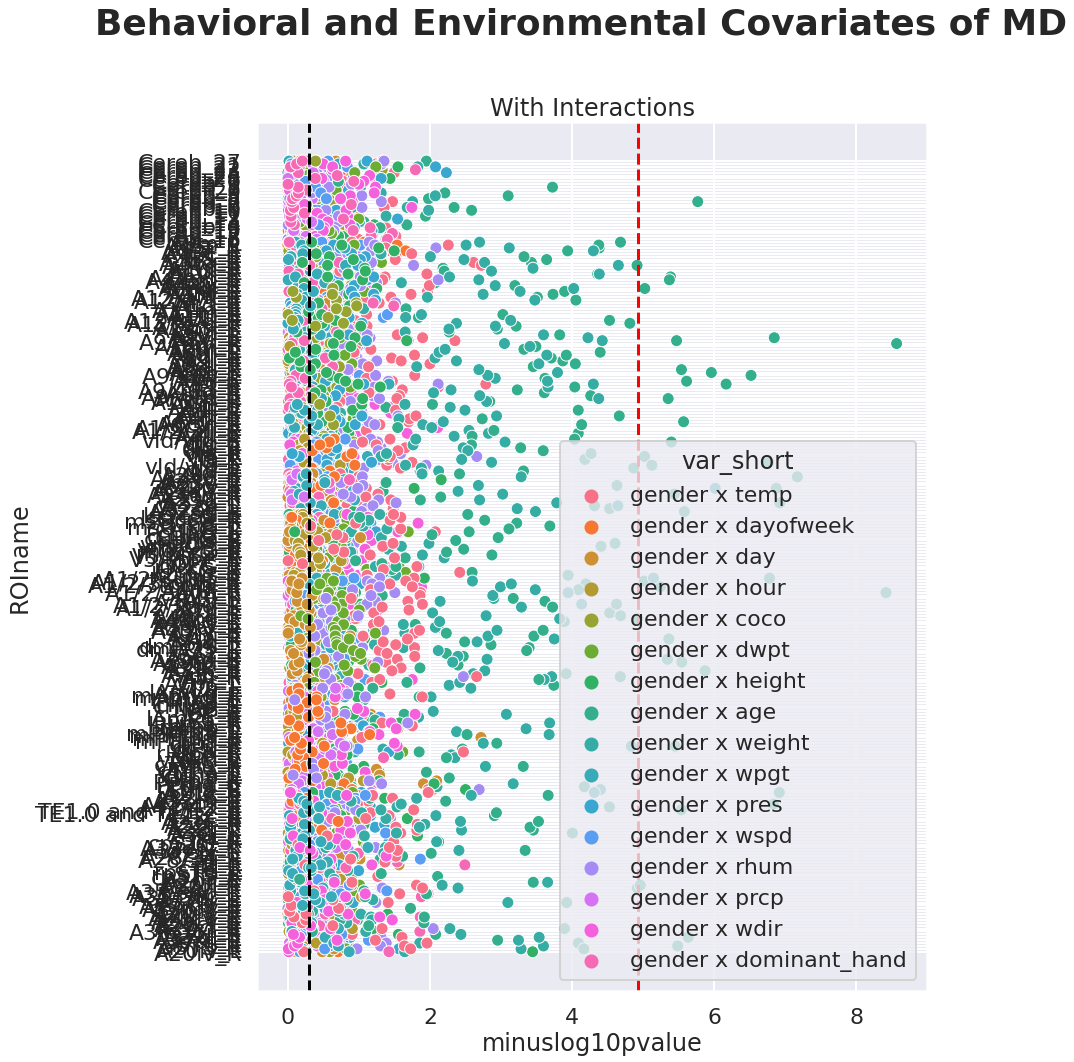

In [24]:
import numpy as np

sns.set_theme("poster")
stats["minuslog10pvalue"] = -np.log10(stats.p)
fig = plt.figure(figsize=(12, 16))

# sns.scatterplot(data=stats.query("var_group != 'behavioral x environmental'"),x="minuslog10pvalue",y="Label",hue="var_group",hue_order=["behavioral","environmental"])
# sns.scatterplot(
#     data=stats.sort_values("Lobe"), x="minuslog10pvalue", y="ROIname", hue="var_group", hue_order=["behavioral", "environmental", "behavioral x environmental"]
# )
sns.scatterplot(
    data=stats[stats["var_short"].str.contains("gender x ")].sort_values("Lobe"), x="minuslog10pvalue", y="ROIname", hue="var_short"
)

plt.axvline(-np.log10(0.5), color="black", linestyle="--")
plt.axvline(-np.log10(0.5 / stats.shape[0]), color="red", linestyle="--")
# plt.plot(-np.log10([0.5 / stats.shape[0], 0.5 / stats.shape[0]]), [0, 275], color="red", linestyle="--")
plt.suptitle("Behavioral and Environmental Covariates of MD", fontsize=36, fontweight="bold")
plt.title("With Interactions", fontsize=24)

153